In [ ]:
!nvidia-smi

In [ ]:
!pip install torchvision==0.9.1
!pip install tqdm


In [2]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.decomposition import PCA

In [7]:
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
nw = 0
bs = 64
vsize = 0.2

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

td = datasets.CIFAR10('data', train=True, download=True, transform=transform)
testd = datasets.CIFAR10('data', train=False, download=True, transform=transform)

tl = len(td)
i = list(range(tl))
np.random.shuffle(i)
split = int(np.floor(vsize * tl))
ti, vi = i[split:], i[:split]

training_data = SubsetRandomSampler(ti)
validation_data = SubsetRandomSampler(vi)

train_loader = torch.utils.data.DataLoader(td, batch_size=bs,
    sampler=training_data, num_workers=nw)
valid_loader = torch.utils.data.DataLoader(td, batch_size=bs, 
    sampler=validation_data, num_workers=nw)
test_loader = torch.utils.data.DataLoader(testd, batch_size=bs, 
    num_workers=nw)


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
print('debug 2.....')


Files already downloaded and verified
Files already downloaded and verified
debug 2.....


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
def train_model(model):
    training_losses = []
    test_losses = []
    n_epochs = [*range(10)]
    test_acc = []
    train_acc=[]
    for epoch in range(1, len(n_epochs)+1):
        running_loss = 0.0
        correct1 = 0
        total1 = 0
        model.train()
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total1 += labels.size(0)
            correct1 += (predicted == labels).sum().item()
            running_loss += loss.item()
        
        training_loss = running_loss / len(train_loader)
        accuracy1 = round( correct1 / total1,3)
    
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
        test_loss /= len(test_loader)
        accuracy = round( correct / total,3)
        training_losses.append(training_loss)
        train_acc.append(accuracy1)
        test_losses.append(test_loss)
        test_acc.append(accuracy)
        print('Epoch: {} Training Loss: {:.4f} Test Loss: {:.4f}'.format(epoch, training_loss, test_loss))
        print('Epoch: {} Training acc: {:.4f} Test acc: {:.4f}'.format(epoch, accuracy1, accuracy))
    return (training_losses,test_losses,train_acc,test_acc)

In [11]:
model1 = Net()
if train_on_gpu:
  model1.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9) 
print(model1)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [12]:
model2 = Net()
if train_on_gpu:
  model2.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.0001, weight_decay = 0.005, momentum = 0.9) 
print(model2)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [20]:
m1_trainloss,m1_testloss,m1_trainacc,m1_testacc=train_model(model1)

Epoch: 1 Training Loss: 2.3054 Test Loss: 2.3051
Epoch: 1 Training acc: 0.1000 Test acc: 0.1010
Epoch: 2 Training Loss: 2.3053 Test Loss: 2.3051
Epoch: 2 Training acc: 0.1000 Test acc: 0.0990
Epoch: 3 Training Loss: 2.3054 Test Loss: 2.3051
Epoch: 3 Training acc: 0.0990 Test acc: 0.1020
Epoch: 4 Training Loss: 2.3054 Test Loss: 2.3051
Epoch: 4 Training acc: 0.0990 Test acc: 0.1010
Epoch: 5 Training Loss: 2.3054 Test Loss: 2.3052
Epoch: 5 Training acc: 0.1000 Test acc: 0.1000
Epoch: 6 Training Loss: 2.3052 Test Loss: 2.3050
Epoch: 6 Training acc: 0.0990 Test acc: 0.0990
Epoch: 7 Training Loss: 2.3053 Test Loss: 2.3051
Epoch: 7 Training acc: 0.0990 Test acc: 0.1000
Epoch: 8 Training Loss: 2.3052 Test Loss: 2.3049
Epoch: 8 Training acc: 0.1010 Test acc: 0.1030
Epoch: 9 Training Loss: 2.3053 Test Loss: 2.3049
Epoch: 9 Training acc: 0.1010 Test acc: 0.1010
Epoch: 10 Training Loss: 2.3054 Test Loss: 2.3050
Epoch: 10 Training acc: 0.1000 Test acc: 0.1010
Epoch: 11 Training Loss: 2.3053 Test L

In [21]:
m2_trainloss,m2_testloss,m2_trainacc,m2_testacc=train_model(model2)

Epoch: 1 Training Loss: 2.3050 Test Loss: 2.3051
Epoch: 1 Training acc: 0.1020 Test acc: 0.1010
Epoch: 2 Training Loss: 2.3046 Test Loss: 2.3044
Epoch: 2 Training acc: 0.1030 Test acc: 0.1050
Epoch: 3 Training Loss: 2.3040 Test Loss: 2.3038
Epoch: 3 Training acc: 0.1040 Test acc: 0.1060
Epoch: 4 Training Loss: 2.3036 Test Loss: 2.3035
Epoch: 4 Training acc: 0.1050 Test acc: 0.1040
Epoch: 5 Training Loss: 2.3032 Test Loss: 2.3029
Epoch: 5 Training acc: 0.1060 Test acc: 0.1070
Epoch: 6 Training Loss: 2.3029 Test Loss: 2.3027
Epoch: 6 Training acc: 0.1060 Test acc: 0.1050
Epoch: 7 Training Loss: 2.3024 Test Loss: 2.3029
Epoch: 7 Training acc: 0.1040 Test acc: 0.1060
Epoch: 8 Training Loss: 2.3022 Test Loss: 2.3019
Epoch: 8 Training acc: 0.1060 Test acc: 0.1090
Epoch: 9 Training Loss: 2.3019 Test Loss: 2.3017
Epoch: 9 Training acc: 0.1070 Test acc: 0.1110
Epoch: 10 Training Loss: 2.3017 Test Loss: 2.3015
Epoch: 10 Training acc: 0.1060 Test acc: 0.1100
Epoch: 11 Training Loss: 2.3013 Test L

20
[2.305365545654297, 2.3053169784545897, 2.305378580856323, 2.3053864990234376, 2.305358293533325, 2.3052336910247804, 2.3053186763763427, 2.305242613220215, 2.305254214859009, 2.305393923187256, 2.305298527908325, 2.3053821483612063, 2.3052298919677736, 2.3053012798309327, 2.305322657394409, 2.3052258563995363, 2.3054196998596193, 2.305429250717163, 2.3053062816619874, 2.305465273284912]


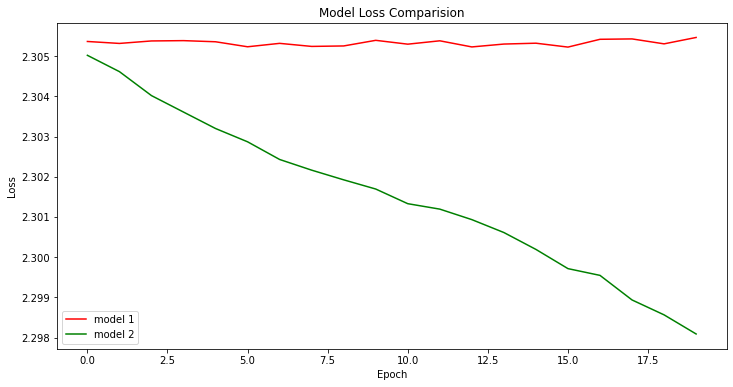

In [25]:
n_epochs=[*range(20)]
plt.figure(figsize=(12,6))
print(len(n_epochs))
print(m1_trainloss)
plt.plot(n_epochs, m1_trainloss, color = "r")
plt.plot(n_epochs, m2_trainloss, color = "g")
plt.title('Model Loss Comparision')
plt.legend(['model 1', 'model 2'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

20
[2.305365545654297, 2.3053169784545897, 2.305378580856323, 2.3053864990234376, 2.305358293533325, 2.3052336910247804, 2.3053186763763427, 2.305242613220215, 2.305254214859009, 2.305393923187256, 2.305298527908325, 2.3053821483612063, 2.3052298919677736, 2.3053012798309327, 2.305322657394409, 2.3052258563995363, 2.3054196998596193, 2.305429250717163, 2.3053062816619874, 2.305465273284912]


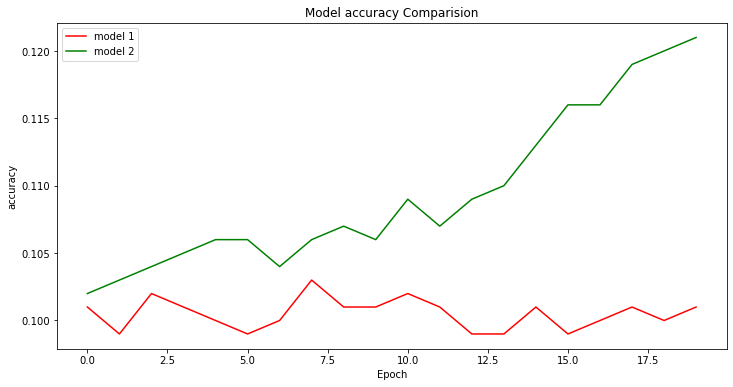

In [26]:
plt.figure(figsize=(12,6))
print(len(n_epochs))
print(m1_trainloss)
plt.plot(n_epochs, m1_trainacc, color = "r")
plt.plot(n_epochs, m2_testacc, color = "g")
plt.title('Model accuracy Comparision')
plt.legend(['model 1', 'model 2'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

In [27]:
def calculate_loss(model, loader):
    correct = 0
    total = 0
    costTotal = 0
    costCounter = 0
    with torch.no_grad():
        for batch in loader:
            data, target = batch
            data, target = data.to(device), target.to(device)
            output = model(data)
            cost = criterion(output, target)
            costTotal += cost
            costCounter += 1
            for i, outputTensor in enumerate(output):
                if torch.argmax(outputTensor) == target[i]:
                    correct += 1
                total += 1
    return costTotal / costCounter, round(correct/total, 3)

In [28]:
m1_param = torch.nn.utils.parameters_to_vector(model1.parameters())
m2_param = torch.nn.utils.parameters_to_vector(model2.parameters())
alpha = np.linspace(-2.0, 2.0, num = 20)
thetaArr =[]
for i in range (len(alpha)):
    theta = (1-alpha[i])*m1_param + alpha[i]* m2_param
    thetaArr.append(theta)

In [30]:
m3_trainloss_list = []
m3_testloss_list = []
m3_testacc_list = []
m3_trainacc_list = []

In [31]:
for i in range (len(thetaArr)):
    theta = (1-alpha[i])* m1_param + alpha[i]*m2_param
    theta=theta.to(device)
    model3 = Net()
    if train_on_gpu:
        model3.cuda()
    torch.nn.utils.vector_to_parameters(theta, model3.parameters())
    criterion = nn.CrossEntropyLoss()
    print(alpha[i])

    temp = []
    for param in model3.parameters():
        temp.append(torch.numel(param))

    m3_trainloss,m3_trainacc=calculate_loss(model3,train_loader)
    m3_testloss,m3_testacc=calculate_loss(model3,test_loader)
    m3_trainloss_list.append(m3_trainloss)
    m3_trainacc_list.append(m3_trainacc)
    m3_testloss_list.append(m3_testloss)
    m3_testacc_list.append(m3_testacc)

-2.0
-1.7894736842105263
-1.5789473684210527
-1.368421052631579
-1.1578947368421053
-0.9473684210526316
-0.736842105263158
-0.5263157894736843
-0.3157894736842106
-0.10526315789473695
0.10526315789473673
0.3157894736842106
0.5263157894736841
0.7368421052631575
0.9473684210526314
1.1578947368421053
1.3684210526315788
1.5789473684210522
1.789473684210526
2.0


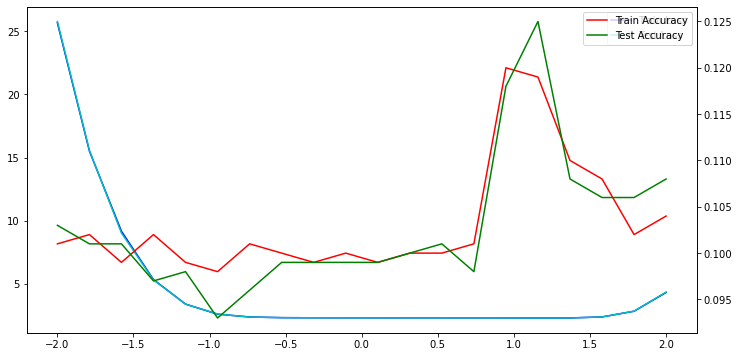

In [32]:
plt.figure(figsize=(12,6))
plt.plot(alpha, [t.cpu().numpy() for t in m3_trainloss_list], color = "b")
plt.plot(alpha, [t.cpu().numpy() for t in m3_testloss_list], color = "c")
plt.legend(['Train Loss' , 'Test Loss'])

plt.twinx()

m3_trainacc_list = torch.tensor(m3_trainacc_list)
m3_testacc_list = torch.tensor(m3_testacc_list)
plt.plot(alpha, [t.cpu().numpy() for t in m3_trainacc_list], color = "r")
plt.plot(alpha, [t.cpu().numpy() for t in m3_testacc_list], color = "g")
plt.legend(['Train Accuracy' , 'Test Accuracy'])